#**Previsão de demanda de energia elétrica por clientes da região Nordeste do Brasil**

# Sumário
- [1. Introdução](#1)
- [2. Objetivos específicos](#2)
- [3. Base de dados](#3)
    - [3.1. Conteúdo da base de dados](#31)
- [4. Análise exploratória dos dados](#4)
    - [4.1. Levantamento de hipóteses](#41)
- [5. Feature Engineering](#5)
- [6. Predição com a biblioteca Prophet](#6)
- [7. Conclusão](#7)

<a name="1"></a>
## 1. Introdução

---

<center>
<img src="https://conteudo.imguol.com.br/c/noticias/38/2019/05/19/linha-de-transmissao-responsavel-por-levar-eletricidade-ate-a-casa-das-pessoas-energia-eletrica-luz-forca-eletrica-1558285927942_v2_1920x1280.jpg"
alt="drawing" width="600", height="400">
</center>

---

<p>A demanda energética trata da necessidade de energia requerida pela população em diversores setores da sociedade. As industrias utilizarão energia para produzir produtos. O comércio consumirá mais energia nas lojas onde esses produtos serão vendidos e nas casas das pessoas que os ultilizará.</p>
<p>A previsão do consumo de energia é de suma importância para o planejamento do país, pois deve-se considerar como toda essa energia será produzida e como ela chegará a todas as pessoas em cada lugar do Brasil. Precisa-se considerar, por exemplo, o quanto as fontes de energia que temos disponíveis no Brasil variam ao longo do dia ou do ano. Além disso,  precisam ser construídas linhas de transmissão, responsáveis por levar a eletricidade das usinas paras as cidades.</p>
<p>Neste projeto, utilizaremos a biblioteca Prophet para prever dados de série temporal da demanda de energia elétrica pela região Nordeste do Brasil. </p>

Fonte:  [EPE, s.d.](https://www.epe.gov.br/pt/abcdenergia/planejamento-energetico-e-a-epe)

<a name="2"></a>
## 2. Objetivos específicos

* Analisar os dados fornecidos para identificar padrões ou acontecimentos ao longo do tempo;
* Prever o consumo de energia elétrica utilizando a biblioteca Prophet.

<a name="3"></a>
## 3. Base de dados

In [3]:
# Importação de bibliotecas

import pandas as pd
import plotly as pl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import plotly.express as pl
import pickle
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import acf, pacf
import plotly.graph_objs as go
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from prophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import itertools
from prophet.plot import plot_plotly, plot_components_plotly

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="31"></a>
### 3.1 Conteúdo da base de dados

O conjunto de dados contém o consumo histórico (em GWh), por mês, de Janeiro de 1979 até Março de 2021, por clientes da região Nordeste. Os dados foram obtidos do site [ipeadata](http://www.ipeadata.gov.br/Default.aspx). O Ipeadata é uma base de dados macroeconômicos, financeiros e regionais do Brasil mantida pelo [Ipea](https://www.ipea.gov.br/portal/) (Instituto de Pesquisa Econômica Aplicada).

In [5]:
# obtenção dos dados 
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Série temporal DataSet/ipeadata[19-06-2021-08-55].csv')
df

,Data;Consumo - energia elétrica - Região Nordeste (NE) - qde. - GWh - Eletrobras - ELETRO12_CEENE12;
0,1979.01;1031;
1,1979.02;1029;
2,1979.03;1036;
3,1979.04;992;
4,1979.05;1028;
...,...
502,2020.11;7023;
503,2020.12;7098;
504,2021.01;7399;
505,2021.02;7025;


In [6]:
# separando a coluna em data e consumo

df = df['Data;Consumo - energia elétrica - Região Nordeste (NE) - qde. - GWh - Eletrobras - ELETRO12_CEENE12;'].str.split(';', expand=True)

In [7]:
# excluindo a coluna vazia gerada

df = df.drop(columns=[2])

In [8]:
# renomeando as colunas

df = df.rename(columns={0: "data", 1: "consumo (GWh)"})

In [9]:
# usando a função to_datetime para formatar as datas

df['data'] = pd.to_datetime(df['data'], errors='coerce')

In [10]:
# convertendo a coluna 'consumo (GWh)' para númerico

df['consumo (GWh)'] = pd.to_numeric(df['consumo (GWh)'])

In [11]:
# transformando a coluna 'data' em índice

df.set_index('data', inplace=True)

In [12]:
# visualizando o dataframe

df

,consumo (GWh)
data,
1979-01-01,1031
1979-02-01,1029
1979-03-01,1036
1979-04-01,992
1979-05-01,1028
...,...
2020-11-01,7023
2020-12-01,7098
2021-01-01,7399


<a name="4"></a>
## 4. Análise exploratória dos dados

<a name="41"></a>
### 4.1 Levantamento de hipóteses

1.   A série temporal possui alguma tendência?
2.   Há alterações abruptas significativas no consumo de energia ao longo do tempo?
3.   Existem razôes politico-econômicas para as alterações no consumo?
4.   Quais meses do anos há aumento e diminuição no consumo?


In [13]:
# visualizando gráfico do conjunto de dados

df['mean'] = df['consumo (GWh)'].rolling(12).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x = df.index, y = df['mean'], name = 'Média',))
fig.add_trace(go.Scatter(x = df.index, y = df['consumo (GWh)'], name = 'Consumo',))
fig.show()

fig.write_html("media.html")

É possível observar que a série temporal possui tendência de crescimento. Isso pode ser explicado pelo aumento da população, segundo o IBGE, em 1979 a população do nordeste era de cerca de 35 milhôes de pessoas¹, em 2020 a população é de cerca de 57 milhões de pessoas², ainda de acordo com o IBGE. <p>
Ainda observa-se que entre os meses de Maio à Julho de 2001, há uma grande queda no consumo de energia, isso é justificado pelo corte de energia programado para conter o consumo e evitar colapso no abastecimento de energia elétrica em todo país, devido ao atraso em obras de transmissão e geração de energia, segundo relatório escrito pela Comissão de Análise do Sistema Hidrotérmico de Energia Elétrica, em julho de 2001³.

¹[IBGE, Estatísticas do século XX, 2021.](https://seculoxx.ibge.gov.br/images/seculoxx/arquivos_download/populacao/1979/populacao_m_1979aeb_012.pdf) <p>
²[IBGE, 2021.](https://sidra.ibge.gov.br/tabela/6579#resultado) <p>
³[Folha de São Paulo, 2005.](https://www1.folha.uol.com.br/fsp/dinheiro/fi1511200531.htm)


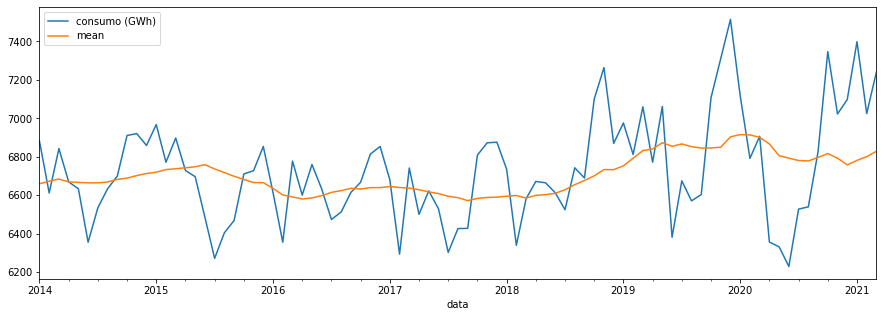

In [14]:
# plotando gráfico do tempo a partir do ano de 2014 com a média móvel

filtro = (df.index.year >= 2014)

df[filtro].plot(figsize = (15, 5))

Verificando o gráfico a partir do ano de 2014, observa-se certa estagnação no consumo de energia. Isso é atribuída à recessão econômica que enfrenta o país⁴. Ainda, verifica-se uma maior queda em 2020 devido a crise causada pela pandemia do Covid-19.

⁴[Agência Brasil, 2016.](https://agenciabrasil.ebc.com.br/economia/noticia/2016-12/ons-crise-faz-consumo-de-energia-em-2016-se-manter-no-mesmo-nivel-de-2015)

Como o consumo de energia está relacionado diretamente pelo desevolvimento econômico do país, a partir deste ponto, utilizaremos os dados a partir do ano de 2002. Pois, anteriormente, os dados fornecidos tem relação apenas quanto ao crescimento da população, e não haverá grande influência para o objeto de estudo deste projeto.

In [15]:
# Utilizando os dados a partir do ano de 2002

df = df[df.index > '2002']

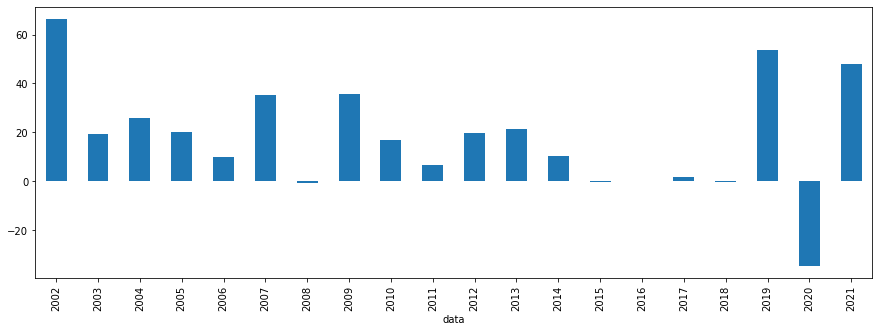

In [16]:
# plotando gráfico de barras com diferenciação e média por ano para análise

df['consumo (GWh)'].diff().groupby(df.index.year).mean().plot(kind='bar', figsize = (15, 5))

No gráfico acima fica claro o baixo consumo de energia entre os anos de 2015 e 2018 e a grande queda em 2020 precedido pelo aumento de consumo em 2019.

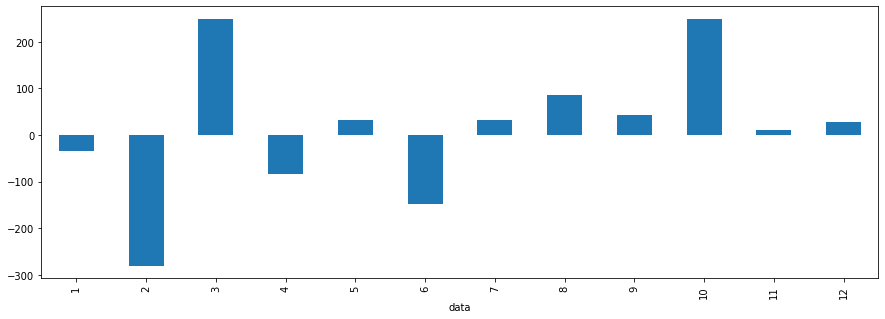

In [17]:
# plotando gráfico de barras com diferenciação e média por mês para análise


df['consumo (GWh)'].diff().groupby(df.index.month).mean().plot(kind='bar', figsize = (15, 5))

O gráfico acima mostra que em média há uma queda de consumo nos meses de  Fevereiro, Abril e Junho, com aumento no consumo em Março, Agosto e Outubro.

In [18]:
# excluindo a coluna média 

df = df.drop(columns='mean')

In [19]:
# excluindo valores ausentes

df = df.dropna()

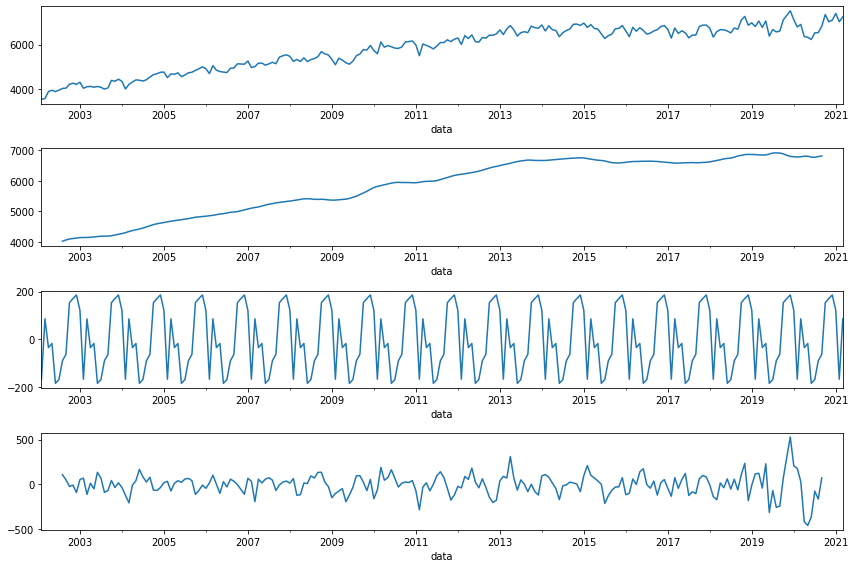

In [20]:
# visualizando a tendência, sazionalidade e resíduos dos dados

result = seasonal_decompose(df['consumo (GWh)'])

# configurando o tamanho do gráfico

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

plt.tight_layout()

<a name="5"></a>
## 5. Feature engineering

In [21]:
# criando cópia do dataframe

df_copy = df

Em séries temporais, geralmente é útil fazer alguma forma de transformação de potência dos dados para estabilizar a variância e tornar os dados mais semelhantes a uma distribuição normal. Usaremos uma transformação Box Cox que avalia um conjunto de coeficientes lambda (λ) e seleciona o valor que atinge a melhor aproximação da normalidade.

In [22]:
# Aplicando transformação Box-Cox e salvando o valor de lambda para realizar posterior inversão


df_copy['consumo (GWh)'], lam = boxcox(df_copy['consumo (GWh)'])
print('Lambda:', lam)

Lambda: 2.4488680409470422


In [23]:
# vizualizando gráfico com a série trasnformada

fig = pl.line(df_copy, x=df_copy.index,  y= df_copy['consumo (GWh)'])

fig.show()

fig.write_html("boxcox.html")

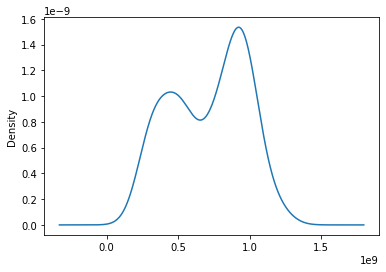

In [24]:
# visualizando o histograma dos dados para verificar a distribuição

df_copy['consumo (GWh)'].plot(kind='kde')
plt.show()

<a name="6"></a>
## 6. Predição com a biblioteca Prophet

A biblioteca Prophet é uma ferramenta *open source* lançada pelo *Facebook* em 2017. A ferramenta visa contribuir para problemas de geração de previsões e cenários futuros para séries temporais. Veja as características do Prophet (em que ele é melhor, segundo o site oficial⁵):
* Observações horárias, diárias ou semanais com pelo menos alguns meses (preferivelmente um ano) de histórico.
* Fortes sazonalidades múltiplas em “escala humana”: dia da semana e época do ano.
* Feriados importantes que ocorrem em intervalos irregulares que são conhecidos antecipadamente.
* Um número razoável de observações ausentes ou grandes outliers,
mudanças históricas de tendência, por exemplo, devido a lançamentos de produtos ou alterações no registro.
* Tendências que são curvas de crescimento não lineares, em que uma tendência atinge um limite natural ou satura.  

Para modelar séries temporais, o Prophet separa o sinal nos seguintes componentes aditivos: tendêndia, sazionalidade e feriados. De acordo com a formula abaixo: 

<center>
<img src="https://images.ctfassets.net/pqts2v0qq7kz/3glP09bVlIt1K88xxFVE4C/dda51e12a4975208577a04e38fa285f3/1.png">
</center>

Onde:<p>
**g(t)** é a função de tendência que modela mudanças não periódicas no valor da série temporal;<p>
**s(t)** representa mudanças periódicas (por exemplo, sazionalidade semanal ou anual) <p>
**h(t)** representa o efeito de feriados
que ocorrem em programações potencialmente irregulares ao longo de um ou mais dias. <p>
**εₜ** é é o erro / ruído do modelo, que é considerado normalmente distribuído.




⁵[Facebook Prophet, 2017.](https://facebook.github.io/prophet/)


In [25]:
# formatando o dataframe para o padrão da biblioteca prophet

df_prophet = df_copy.reset_index()
df_prophet = df_prophet.rename(columns={'data':'ds', 'consumo (GWh)':'y'})

In [26]:
# visulizando o dataframe formatado

df_prophet.head()

,ds,y
0,2002-02-01,2.027082e+08
1,2002-03-01,2.064981e+08
2,2002-04-01,2.539833e+08
3,2002-05-01,2.633355e+08
4,2002-06-01,2.536644e+08


Abaixo é criado um dataframe com os principais feriados do Brasil para ser implementado no governo.

In [27]:
# criando dataframe com feriados do Brasil

ano_novo = pd.DataFrame({
    'holiday': 'ano_novo',
    'ds': pd.to_datetime(['2002-01-01', '2003-01-01', '2004-01-01', 
                          '2005-01-01', '2006-01-01', '2006-01-01',
                          '2007-01-01', '2008-01-01', '2009-01-01',
                          '2010-01-01', '2011-01-01', '2012-01-01',
                          '2013-01-01', '2014-01-01', '2015-01-01',
                          '2016-01-01', '2017-01-01', '2018-01-01',
                          '2019-01-01', '2020-01-01', '2021-01-01']),
})

pascoa = pd.DataFrame({
    'holiday': 'pascoa',
    'ds': pd.to_datetime(['2002-04-05', '2003-04-05', '2004-04-05', 
                          '2005-04-05', '2006-04-05', '2006-04-05',
                          '2007-04-05', '2008-04-05', '2009-04-05',
                          '2010-04-05', '2011-04-05', '2012-04-05',
                          '2013-04-05', '2014-04-05', '2015-04-05',
                          '2016-04-05', '2017-04-05', '2018-04-05',
                          '2019-04-05', '2020-04-05', '2021-04-05']),
})

tiradentes = pd.DataFrame({
    'holiday': 'tiradentes',
    'ds': pd.to_datetime(['2002-04-21', '2003-04-21', '2004-04-21', 
                          '2005-04-21', '2006-04-21', '2006-04-21',
                          '2007-04-21', '2008-04-21', '2009-04-21',
                          '2010-04-21', '2011-04-21', '2012-04-21',
                          '2013-04-21', '2014-04-21', '2015-04-21',
                          '2016-04-21', '2017-04-21', '2018-04-21',
                          '2019-04-21', '2020-04-21', '2021-04-21']),
})
trabalho = pd.DataFrame({
    'holiday': 'trabalho',
    'ds': pd.to_datetime(['2002-05-01', '2003-05-01', '2004-05-01', 
                          '2005-05-01', '2006-05-01', '2006-05-01',
                          '2007-05-01', '2008-05-01', '2009-05-01',
                          '2010-05-01', '2011-05-01', '2012-05-01',
                          '2013-05-01', '2014-05-01', '2015-05-01',
                          '2016-05-01', '2017-05-01', '2018-05-01',
                          '2019-05-01', '2020-05-01', '2021-05-01']),
})
independencia = pd.DataFrame({
    'holiday': 'independencia',
    'ds': pd.to_datetime(['2002-09-07', '2003-09-07', '2004-09-07', 
                          '2005-09-07', '2006-09-07', '2006-09-07',
                          '2007-09-07', '2008-09-07', '2009-09-07',
                          '2010-09-07', '2011-09-07', '2012-09-07',
                          '2013-09-07', '2014-09-07', '2015-09-07',
                          '2016-09-07', '2017-09-07', '2018-09-07',
                          '2019-09-07', '2020-09-07', '2021-09-07']),

})
finados = pd.DataFrame({
    'holiday': 'finados',
    'ds': pd.to_datetime(['2002-11-02', '2003-11-02', '2004-11-02', 
                          '2005-11-02', '2006-11-02', '2006-11-02',
                          '2007-11-02', '2008-11-02', '2009-11-02',
                          '2010-11-02', '2011-11-02', '2012-11-02',
                          '2013-11-02', '2014-11-02', '2015-11-02',
                          '2016-11-02', '2017-11-02', '2018-11-02',
                          '2019-11-02', '2020-11-02', '2021-11-02']),

})
republica = pd.DataFrame({
    'holiday': 'republica',
    'ds': pd.to_datetime(['2002-11-15', '2003-11-15', '2004-11-15', 
                          '2005-11-15', '2006-11-15', '2006-11-15',
                          '2007-11-15', '2008-11-15', '2009-11-15',
                          '2010-11-15', '2011-11-15', '2012-11-15',
                          '2013-11-15', '2014-11-15', '2015-11-15',
                          '2016-11-15', '2017-11-15', '2018-11-15',
                          '2019-11-15', '2020-11-15', '2021-11-15']),

})    
natal = pd.DataFrame({
    'holiday': 'natal',
    'ds': pd.to_datetime(['2002-12-25', '2003-12-25', '2004-12-25', 
                          '2005-12-25', '2006-12-25', '2006-12-25',
                          '2007-12-25', '2008-12-25', '2009-12-25',
                          '2010-12-25', '2011-12-25', '2012-12-25',
                          '2013-12-25', '2014-12-25', '2015-12-25',
                          '2016-12-25', '2017-12-25', '2018-12-25',
                          '2019-12-25', '2020-12-25', '2021-12-25']),

})    


holidays = pd.concat((ano_novo, pascoa, tiradentes, trabalho, independencia, finados, republica, natal))

In [29]:
# visualizando o dataframe dos feriados

holidays

,holiday,ds
0,ano_novo,2002-01-01
1,ano_novo,2003-01-01
2,ano_novo,2004-01-01
3,ano_novo,2005-01-01
4,ano_novo,2006-01-01
...,...,...
16,natal,2017-12-25
17,natal,2018-12-25
18,natal,2019-12-25
19,natal,2020-12-25


In [30]:
# instanciando a biblioteca Prophet

m = Prophet(holidays=holidays)

A biblioteca Prophet permitel dividir os dados históricos em dados de treinamento e dados de teste para validação cruzada. Os principais conceitos para validação cruzada com o Profeta são:

* Dados de treinamento (*initial*): A quantidade de dados reservada para treinamento. O parâmetro está na API denominado inicial.<p>
* Horizonte (*horizon*): os dados reservados para validação. Se não definir um período, o modelo é ajustado com horizon/2.<p>
* Período (*cutoff*): uma previsão é feita para cada ponto observado entre o cutoff e o cutoff + horizonte.

Adicionalmente, testaremos diferentes hiperparâmetros em um loop e, em seguida, obteremos os melhores, com o objetivo de melhorar o modelo. Esse processo é relativamente custoso computacionalmente e leva alguns minutos para ser concluído.

In [31]:
# utilizando a técnica de validação cruzada para obter os melhores parâmetros do modelo

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays=holidays).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 17 forecasts with cutoffs between 2004-03-05 00:00:00 and 2020-03-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbb581e10d0>
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 17 forecasts with cutoffs between 2004-03-05 00:00:00 and 2020-03-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbb581ead90>
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:Disabling w

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  9.366893e+07
1                     0.001                     0.10  9.209460e+07
2                     0.001                     1.00  9.187509e+07
3                     0.001                    10.00  9.248359e+07
4                     0.010                     0.01  8.427203e+07
5                     0.010                     0.10  8.215818e+07
6                     0.010                     1.00  8.261142e+07
7                     0.010                    10.00  8.238176e+07
8                     0.100                     0.01  7.428289e+07
9                     0.100                     0.10  7.432288e+07
10                    0.100                     1.00  7.451281e+07
11                    0.100                    10.00  7.478194e+07
12                    0.500                     0.01  7.439997e+07
13                    0.500                     0.10  7.466356

In [32]:
# imprimindo os melhores parâmetros

best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [33]:
# serializando os melhores parâmetros 

with open('best_params.pkl', 'wb') as file:
    pickle.dump(best_params, file)

with open('m.pkl', 'wb') as file:
    pickle.dump(m, file)

with open('cv.pkl', 'wb') as file:
    pickle.dump(df_cv, file)

with open('df_p.pkl', 'wb') as file:
    pickle.dump(df_p, file)

In [34]:
# exibindo o dataframe criado pela validação cruzada

df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-04-01,3.661892e+08,3.626195e+08,3.697989e+08,3.279610e+08,2004-03-05
1,2004-05-01,3.419475e+08,3.300646e+08,3.545972e+08,3.452969e+08,2004-03-05
2,2004-06-01,2.920403e+08,2.674575e+08,3.172343e+08,3.426247e+08,2004-03-05
3,2004-07-01,3.090663e+08,2.671600e+08,3.492391e+08,3.354335e+08,2004-03-05
4,2004-08-01,3.367171e+08,2.783568e+08,3.948295e+08,3.468294e+08,2004-03-05
...,...,...,...,...,...,...
199,2020-11-01,1.121611e+09,1.070676e+09,1.175262e+09,1.073152e+09,2020-03-01
200,2020-12-01,1.123841e+09,1.076846e+09,1.178305e+09,1.101434e+09,2020-03-01
201,2021-01-01,1.120157e+09,1.068274e+09,1.168566e+09,1.219351e+09,2020-03-01
202,2021-02-01,1.039118e+09,9.865257e+08,1.090529e+09,1.073900e+09,2020-03-01


In [35]:
# exibindo dataframe com as métricas da validação cruzada

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,57 days,4.119421e+15,6.418272e+07,4.706192e+07,0.067704,0.059470,0.065914,0.25
1,58 days,4.620393e+15,6.797347e+07,5.205964e+07,0.071770,0.061977,0.070083,0.25
2,59 days,4.896364e+15,6.997403e+07,5.488513e+07,0.071824,0.059901,0.070228,0.25
3,60 days,4.565553e+15,6.756888e+07,5.152346e+07,0.067548,0.054089,0.066047,0.30
4,61 days,7.056851e+15,8.400506e+07,6.152409e+07,0.079710,0.058515,0.076606,0.25


In [36]:
# exibindo a média das métricas

df_p.mean()

horizon     212 days 00:00:00
mse               5.80326e+15
rmse              7.56418e+07
mae               5.87644e+07
mape                0.0781751
mdape               0.0658444
smape               0.0776066
coverage             0.360455
dtype: object

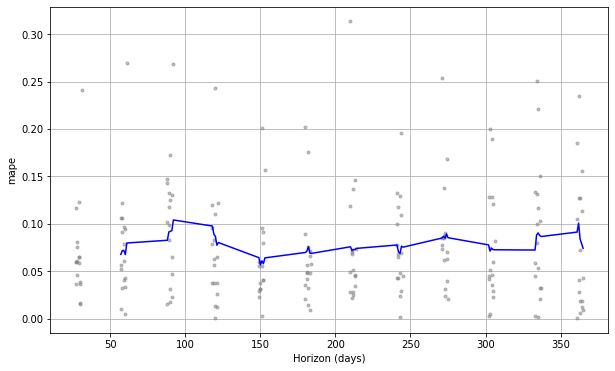

In [37]:
# visualizando gráfico com a métrica mape na validação cruzada

plot_cross_validation_metric(df_cv, metric='mape')

plt.show()

Com o modelo treinado, realizaremos previsão para os próximos 3 anos.

In [38]:
# criando dataframe com datas para previsão dos próximos três anos 

future = m.make_future_dataframe(periods=36, freq='M')
future.tail()

,ds
261,2023-10-31
262,2023-11-30
263,2023-12-31
264,2024-01-31
265,2024-02-29


In [39]:
# realizando predição 

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
261,2023-10-31,1.253688e+09,1.182254e+09,1.326056e+09
262,2023-11-30,1.264894e+09,1.187935e+09,1.337656e+09
263,2023-12-31,1.234113e+09,1.166054e+09,1.312672e+09
264,2024-01-31,1.085604e+09,1.014697e+09,1.163438e+09
265,2024-02-29,1.184971e+09,1.108140e+09,1.259169e+09


In [40]:
# visualizando gráfico com os valores atuais, preditos e feriados

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], name='Atuais',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Preditos',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Feriados'))
fig.show()

fig.write_html("feriados.html")

Observa-se no gráfico acima que os feriados de Janeiro e Maio tem maior influência no consumo de energia.

In [41]:
# exibindo o gráfico com intervalo de incerteza

plot_plotly(m, forecast)

fig.write_html("incerteza.html")

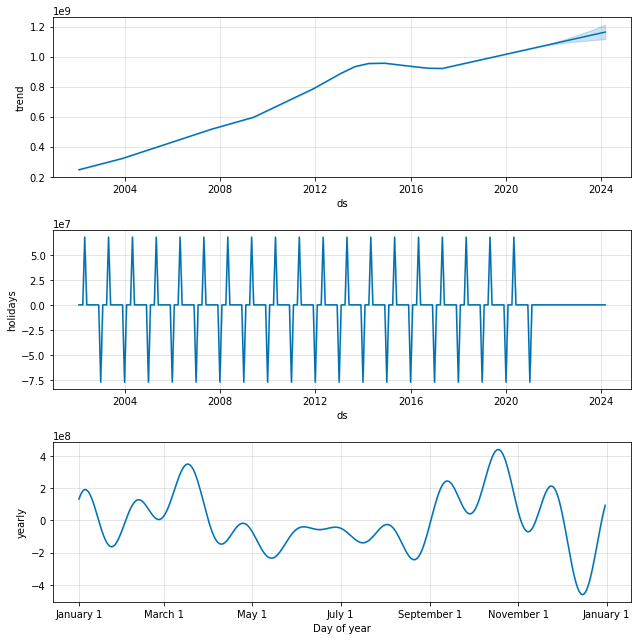

In [44]:
# visualizando os componentes da previsão, incluindo: tendência, feriados e sazionalidade anual

fig2 = m.plot_components(forecast)

In [42]:
# criando cópia do dataframe com as previsões

forecast_copy = forecast

In [43]:
# Transformando os dados para a realidade utilizando o Box-Cox inverso

forecast_copy[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
df_prophet['y'] = inv_boxcox(df_prophet['y'], lam)

# Exibindo os resultados 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_prophet['ds'], y=df_prophet['y'], name='Atual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Previsto',))
fig.show()

fig.write_html("final.html")

<a name="7"></a>
## 7. Conclusão

A previsão da demanda de energia é uma tarefa com diversas incertezas, pois para gerar um modelo de previsão de demanda preciso, devem ser analisadas as questões de crescimento econômico, demográfico, de autoprodutor e tecnológico do país. Percebe-se ainda que influências externas de caráter político podem intervir no processo de modelagem e previsão do mercado de energia, não somente quando o 
processo de modelar e prever ocorre no âmbito do planejamento energético de um 
governo, como também no meio corporativo, quando o objetivo é prever e modelar o mercado de energia de uma empresa. <p>
Ainda sim, o modelo de previsão utilizado neste projeto alcançou um MAPE - Erro Percentual Médio Absoluto de 7,82 %. A importância de prever a demanda de energia ao longo do tempo está totalmente ligada à escassez e à necessidade de geração.  Um planejamento de distribuição adequado à demanda é importante para que a perda seja mínima, mesmo porque no país a energia elétrica ainda é cara para o consumidor devido aos custos operacionais.
